In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
y_trainRaw, tX_trainRaw, ids_train = load_csv_data(DATA_TRAIN_PATH)
DATA_TEST_PATH = '../data/test.csv' 
y_testRaw, tX_testRaw, ids_test = load_csv_data(DATA_TEST_PATH)

In [3]:
def split_numerical_categorical(x,cat_cols):
    x_num = np.delete(x,cat_cols,axis = 1)
    x_cat = x[:,cat_cols]
    return x_num, x_cat

def replace_undef_val_with_nan(x):
    return np.where(x == -999.0, np.nan, x)

def nan_standardize_fit(x):                                
    mean = np.nanmean(x, axis = 0)
    std = np.nanstd(x, axis = 0)
    return (x - mean)/std , mean, std

def nan_standardize_with_median_fit(x):                               
    median = np.nanmedian(x, axis = 0)
    iqr,_,_ = calculate_iqr(x)  
    return 2*(x - median)/iqr , median, iqr

def nan_standardize_with_median_transform(x,median,iqr):                             
    return 2*(x - median)/iqr 
    
def nan_standardize_transform(x,mean,std):
    return (x - mean)/std

def relabel_y_non_negative(y):
    new_y = y.copy()
    new_y[new_y == -1] = 0
    return new_y
 
def relabel_y_negative(y):
    new_y = y.copy()
    new_y[new_y == 0] = -1
    return new_y
        
def replace_nan_val_with_mean(x):
    means = np.nanmean(x,axis = 0)
    n_cols = x.shape[1]
    new_x = x.copy()
    for i in range(n_cols):
        new_x[:,i] = np.where(np.isnan(new_x[:,i]), means[i], new_x[:,i])
    return new_x

def replace_nan_val_with_zero(x):
    n_cols = x.shape[1]
    new_x = x.copy()
    for i in range(n_cols):
        new_x[:,i] = np.where(np.isnan(new_x[:,i]), 0, new_x[:,i])
    return new_x

def calculate_iqr(x):
    q1 = np.quantile(x,0.25,axis = 0)
    q3 = np.quantile(x,0.75,axis = 0)
    return q3 - q1, q1, q3

def replace_iqr_outliers(x):
    iqr, q1, q3= calculate_iqr(x)
    upper_bound = q3 + iqr * 1.5
    lower_bound = q1 - iqr * 1.5
    x_trunc_up = np.where(x > upper_bound,upper_bound,x)
    x_trunc_low = np.where(x_trunc_up < lower_bound,lower_bound,x_trunc_up)
    return x_trunc_low

def replace_nan_val_with_median(x):
    medians = np.nanmedian(x,axis = 0)
    n_cols = x.shape[1]
    new_x = x.copy()
    for i in range(n_cols):
        new_x[:,i] = np.where(np.isnan(new_x[:,i]), medians[i], new_x[:,i])
    return new_x

def one_hot_encode(x):
    unique_vals = set(x.ravel())
    # print(unique_vals)
    n_cols = len(unique_vals) - 1 
    ohe_x = np.zeros((x.shape[0],n_cols))
    for (row,col) in enumerate(x):
        if col < n_cols:
            ohe_x[int(row),int(col)] = 1
    return ohe_x

def add_bias(x):
    return np.hstack((np.ones(x.shape[0]).reshape(-1,1),x))
   
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing
    """
    # set seed
    np.random.seed(seed)
    # ***************************************************
    # INSERT YOUR CODE HERE
    # split the data based on the given ratio: TODO
    # ***************************************************
    n_train = round(y.shape[0]*ratio)
    idx = np.random.permutation(range(y.shape[0]))
    x_shuffled = x[idx]
    y_shuffled = y[idx]
    return x_shuffled[:n_train],y_shuffled[:n_train],x_shuffled[n_train:],y_shuffled[n_train:]
    
    
def multiHistPlots(x,figsize = (15,15)):
    n = x.shape[1]
    n_rows = np.ceil(np.sqrt(n)).astype(np.int64)
    n_cols = np.floor(np.sqrt(n)).astype(np.int64)

    if n_rows * n_cols < n:
        n_cols = np.ceil(np.sqrt(n)).astype(np.int64)

    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = figsize)

    c = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if n > 1:
                ax = axes[row][col]
            else:
                ax = axes
            if c < x.shape[1]:
                ax.hist(x[:,c], label = 'feature_{:d}'.format(c),density = True)
                ax.legend(loc = 'upper left')
                ax.set_ylabel('Probability')
                ax.set_xlabel('Value')
            c += 1
    plt.show()    

## Define functions needed for the log and reg_log

### Logistic Regression

In [46]:
def sigmoid(t):
    """Apply sigmoid function on t
    
    Args: 
        t=>(numpy.array): Values to apply sigmoid function
    
    Returns:
        => numpy.array: Calculated values of sigmoid
    """
    
    return 1.0 / (1.0 + np.exp(-t))


def calculate_loss_log(y, tx, w):
    """Compute the cost of log_regression
    
    Args: 
        y =>(numpy.array): Target values
        tx =>(numpy.array): Transposed features
        w => (numpy.array): Weigths 
          
    Returns:
        => numpy.array: Calculated loss
    """
    pred = sigmoid(tx.dot(w))
    loss = y.T.dot(np.log(pred)) + (1 - y).T.dot(np.log(1 - pred))
    return np.squeeze(- loss)

    
def calculate_gradient_log(y, tx, w,):
    """Compute the gradient of loss for log_regression
    
    Args: 
        y =>(numpy.array): Target values
        tx => (numpy.array): Transposed features
        w => (numpy.array): Weigths 
          
    Returns:
        => numpy.array: Calculated logistic gradient
    """

    pred = sigmoid(tx.dot(w))
    grad = tx.T.dot(pred - y)
    return grad


def learning_by_gradient_descent_log(y, tx, w, gamma):
    """Compute the gradient descen using logistic regression
    
    Args: 
        y =>(numpy.array): Target values
        tx => (numpy.array): Transposed features
        w => (numpy.array): Weigths 
        gamma=> (float): the gamma to use.
        
    Returns:
        w =>(numpy.array): Calculated Weights
        loss => (numpy.array): Calculated Loss
    """

    loss = calculate_loss_log(y, tx, w) 
    grad = calculate_gradient_log(y, tx, w)
    w -= gamma * grad
    return loss, w


def learning_by_reg_gradient_descent_log(y, tx, w, gamma, lambda_=0):
    """Compute the gradient descen using logistic regression
    
    Args: 
        y =>(numpy.array): Target values
        tx => (numpy.array): Transposed features
        w => (numpy.array): Weigths 
        gamma=> (float): the gamma to use.
        
    Returns: 
        w =>(numpy.array): Calculated Weights
        loss => (numpy.array): Calculated Loss
    """

    loss = calculate_loss_log(y, tx, w) + lambda_ * np.squeeze(w.T.dot(w))
    grad = calculate_gradient_log(y, tx, w) + 2 * lambda_ * w
    w -= gamma * grad
    return loss, w

def logistic_regression(y, tx, w_initial, max_iters, gamma):
    """Implement logistic regression using gradient descent
    
    Args: 
      y =>(numpy.array): Target values
      tx => (numpy.array): Transposed features
      w_initial => (numpy.array): Initial Weigths 
      max_iters => (int): number of iterations.
      gamma=> (float): the gamma to use.
          
    Returns: 
        w =>(numpy.array): Calculated Weights
        loss => (numpy.array): Calculated Loss
    """

    assert max_iters > 0, "max_iters should be a positive number"
    assert y.shape[0] == tx.shape[0], "y and tx should have the same number of entries (rows)"
    assert tx.shape[1] == w_initial.shape[0], "initial_w should be the same degree as tx"
    
    print_every = 250
    w = w_initial
    losses =[]
    for n_iter in range(max_iters+1):
        loss, w = learning_by_gradient_descent_log(y, tx, w, gamma)
        if (n_iter % print_every == 0):
            # print average loss for the last print_every iterations
            print('iteration\t', str(n_iter), loss)
            losses.append(loss)

            
    loss = learning_by_gradient_descent_log(y, tx, w, gamma)
    
    return w, loss,losses

def reg_logistic_regression(y, tx, w_initial, max_iters, gamma,lambda_):
    """Implement logistic regression using gradient descent
    
    Args: 
        y =>(numpy.array): Target values
        tx => (numpy.array): Transposed features
        w_initial => (numpy.array): Initial Weigths 
        max_iters => (int): number of iterations.
        gamma=> (float): the gamma to use.
          
    Returns: 
        w =>(numpy.array): Calculated Weights
        loss => (numpy.array): Calculated Loss
    """

    assert max_iters > 0, "max_iters should be a positive number"
    assert y.shape[0] == tx.shape[0], "y and tx should have the same number of entries (rows)"
    assert tx.shape[1] == w_initial.shape[0], "initial_w should be the same degree as tx"
    
    print_every = 250
    w = w_initial
    losses =[]
    for n_iter in range(max_iters+1):
        loss, w = learning_by_reg_gradient_descent_log(y, tx, w, gamma,lambda_)
        if (n_iter % print_every == 0):
            # print average loss for the last print_every iterations
            print('iteration\t', str(n_iter), loss)
            losses.append(loss)

            
    loss = learning_by_reg_gradient_descent_log(y, tx, w, gamma,lambda_)
    
    return w, loss,losses

# Preprocessing

In [66]:
cat_cols = [22]
full_x_train_num, full_x_train_cat = split_numerical_categorical(tX_trainRaw,cat_cols)
# Treat numerical values
full_x_train_num_nan = replace_undef_val_with_nan(full_x_train_num)
full_x_train_num_nan_std, train_mean, train_std = nan_standardize_fit(full_x_train_num_nan)
# full_x_train_num_valid_std = replace_nan_val_with_mean(full_x_train_num_nan_std)
full_x_train_num_valid_std = replace_nan_val_with_median(full_x_train_num_nan_std)
full_x_train_num_valid_std = replace_iqr_outliers(full_x_train_num_valid_std)
# Treat categorical values
full_x_train_ohe_cat = one_hot_encode(full_x_train_cat)
full_x_train = np.hstack((add_bias(full_x_train_num_valid_std),full_x_train_ohe_cat))
# Treat labels
full_y_train = y_trainRaw
full_y_train = relabel_y_non_negative(full_y_train).reshape(-1,1)
full_y_train = full_y_train.reshape(-1,1)

In [67]:
x_train, y_train, x_val, y_val = split_data(full_x_train,full_y_train,0.8)


In [69]:
np.unique(y_val)

array([0., 1.])

# Training and evaluation

In [65]:
max_iters = 1000
gamma = 0.000001
w_initial = np.zeros((full_x_train.shape[1], 1))
# weights, loss_tr,losses = logistic_regression(y_train, x_train, w_initial, max_iters, gamma)

In [40]:
loss_tr

array(101451.05276706)

In [ ]:
# y_val = relabel_y_negative(y_val)
# y_pred = predict_labels(weights, x_val)
# from sklearn.metrics import accuracy_score
# accuracy_score(y_val,y_pred)

In [49]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    # ***************************************************
    poly = np.ones((len(x), 1))
    for deg in range(1, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly

In [90]:
degrees = range(1, 6)
lambdas = np.logspace(-4, 0, 10)

rmse_tr = np.zeros((len(lambdas),len(degrees)))
rmse_val = np.zeros((len(lambdas),len(degrees)))
for index_lambda_, lambda_ in enumerate(lambdas):
    print("LAMBDA: ", lambda_)
    for index_degree, degree in enumerate(degrees):
            print("DEGREEE: ", degree)
            x_tr_pol = build_poly(x_train,degree)
            x_val_pol = build_poly(x_val,degree)
            w_initial = np.zeros((x_tr_pol.shape[1], 1))
            weights,_,_ = reg_logistic_regression(y_train, x_tr_pol, w_initial, max_iters, gamma,lambda_)
            loss_train,_ = learning_by_reg_gradient_descent_log(y_train, x_tr_pol, weights, gamma,lambda_)
            loss_val,_ = learning_by_reg_gradient_descent_log(y_val, x_val_pol, weights, gamma,lambda_)
#             rmse_tr.append(np.sqrt(2*loss_train))        
#             rmse_val.append(np.sqrt(2*loss_val))        
            rmse_tr[index_lambda_, index_degree] = np.sqrt(2*loss_train)
            rmse_val[index_lambda_, index_degree] = np.sqrt(2*loss_val)


LAMBDA:  0.0001
DEGREEE:  1
iteration	 0 138629.4361119856
iteration	 250 103165.10366993019
iteration	 500 102262.9880878215
iteration	 750 101778.85616060035
iteration	 1000 101498.15116768729
DEGREEE:  2


C:\Users\AndresMontero\.conda\envs\ML\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


iteration	 0 138629.4361119856
iteration	 250 86240.83526849738
iteration	 500 85034.5293110204
iteration	 750 84618.38991081335
iteration	 1000 84396.91037245818
DEGREEE:  3
iteration	 0 138629.4361119856
iteration	 250 84661.03854650976
iteration	 500 83232.65651117722
iteration	 750 82715.04495158036
iteration	 1000 82433.6149847365
DEGREEE:  4
iteration	 0 138629.4361119856
iteration	 250 101352.03818502187
iteration	 500 99332.61313520228
iteration	 750 98291.89340459749
iteration	 1000 97583.66168458774
DEGREEE:  5
iteration	 0 138629.4361119856


C:\Users\AndresMontero\.conda\envs\ML\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


iteration	 250 153543.3812160889
iteration	 500 nan
iteration	 750 152592.16936868188
iteration	 1000 nan
LAMBDA:  0.0002782559402207126
DEGREEE:  1
iteration	 0 138629.4361119856
iteration	 250 103165.1040817164
iteration	 500 102262.98873909761
iteration	 750 101778.85703253286
iteration	 1000 101498.15222219299
DEGREEE:  2
iteration	 0 138629.4361119856
iteration	 250 86240.83620665241
iteration	 500 85034.53060546619
iteration	 750 84618.39141403673
iteration	 1000 84396.91202867417
DEGREEE:  3
iteration	 0 138629.4361119856
iteration	 250 84661.03953964521
iteration	 500 83232.6579167577
iteration	 750 82715.04660950822
iteration	 1000 82433.61683089849
DEGREEE:  4
iteration	 0 138629.4361119856
iteration	 250 101352.03931008605
iteration	 500 99332.61466336304
iteration	 750 98291.89537899844
iteration	 1000 97583.66406152499
DEGREEE:  5
iteration	 0 138629.4361119856
iteration	 250 153543.3825827024
iteration	 500 nan
iteration	 750 152592.17079626315
iteration	 1000 nan
LAMBDA:

In [91]:
rmse_tr

array([[450.54921029, 410.84358126, 406.03628086, 456.40080073,
        802.80726624],
       [450.54921263, 410.8435853 , 406.03628541, 456.4008077 ,
        802.80727595],
       [450.54921915, 410.84359652, 406.03629806, 456.40082709,
        802.807303  ],
       [450.54923728, 410.84362774, 406.03633328, 456.40088105,
        802.80737826],
       [450.54928774, 410.84371462, 406.03643127, 456.4010312 ,
        802.80758766],
       [450.54942813, 410.84395636, 406.03670394, 456.40144897,
        802.80817033],
       [450.54981877, 410.844629  , 406.03746263, 456.40261144,
        802.8097916 ],
       [450.55090563, 410.84650052, 406.03957356, 456.4058458 ,
        802.81430246],
       [450.55392909, 410.85170696, 406.04544595, 456.4148436 ,
        802.82685104],
       [450.56233579, 410.86618504, 406.06177548, 456.43986506,
        802.86174378]])

In [93]:
np.argmin(rmse_tr)

2

In [95]:
rmse_val

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

In [96]:
np.armgin(rmse_val)

AttributeError: module 'numpy' has no attribute 'armgin'

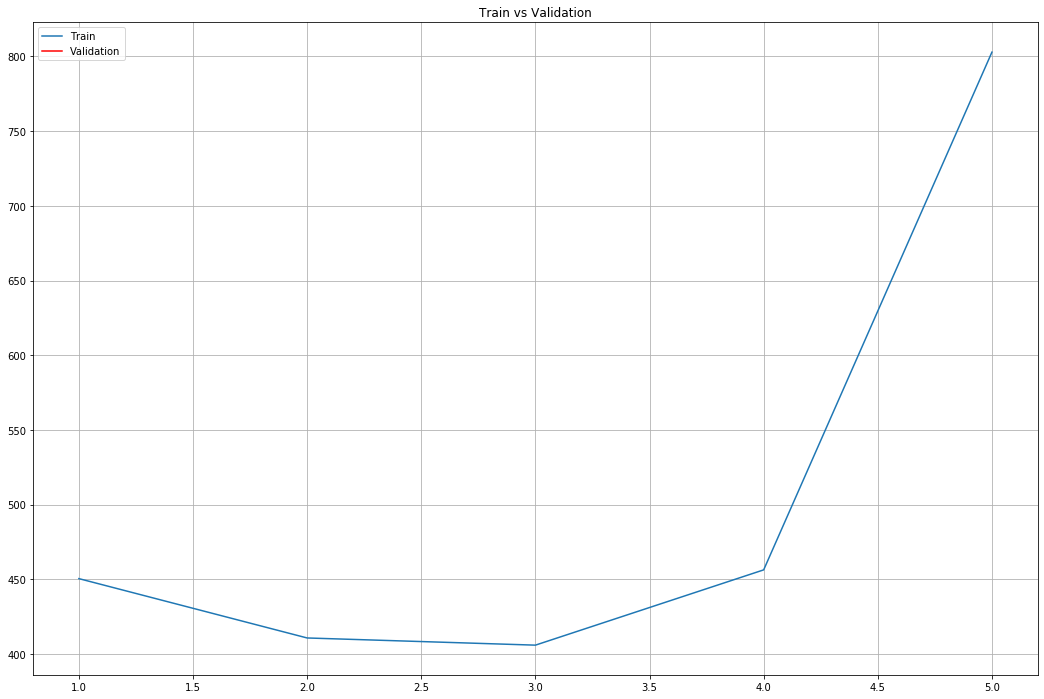

In [100]:
def plot_figures(x_dim, y_dim1, y_dim2, title, legend):
    plt.figure(1, figsize=(18,12))
    plt.title(title)
    plt.plot(x_dim, y_dim1)
    plt.plot(x_dim, y_dim2, 'r')
    plt.grid(True)
    plt.legend(legend)
    plt.show()
plot_figures(degrees, rmse_tr[0], rmse_val[0], "Train vs Validation", ['Train', 'Validation'])

# LogReg with the best degree and gamma

In [82]:
x_tr_pol = build_poly(x_train,3)
x_val_pol = build_poly(x_val,3)
w_initial = np.zeros((x_tr_pol.shape[1], 1))
weights,_,_ = logistic_regression(y_train, x_tr_pol, w_initial, max_iters, gamma)

iteration	 0 138629.4361119856
iteration	 250 84661.03798936956
iteration	 500 83232.65572265898
iteration	 750 82715.0440214974
iteration	 1000 82433.61394905581


In [84]:
y_val = relabel_y_negative(y_val)
y_pred = predict_labels(weights, x_val_pol)
from sklearn.metrics import accuracy_score
accuracy_score(y_val,y_pred)

0.81054

# RegLogReg with the best lambda, degree and gamma

In [101]:
x_tr_pol = build_poly(x_train,3)
x_val_pol = build_poly(x_val,3)
w_initial = np.zeros((x_tr_pol.shape[1], 1))
weights,_,_ = reg_logistic_regression(y_train, x_tr_pol, w_initial, max_iters, gamma,0.0001)

iteration	 0 138629.4361119856
iteration	 250 84661.03854650976
iteration	 500 83232.65651117722
iteration	 750 82715.04495158036
iteration	 1000 82433.6149847365


In [102]:
y_val = relabel_y_negative(y_val)
y_pred = predict_labels(weights, x_val_pol)
from sklearn.metrics import accuracy_score
accuracy_score(y_val,y_pred)

0.81054

In [103]:
cat_cols = [22]
x_test_num, x_test_cat = split_numerical_categorical(tX_testRaw,cat_cols)
# Treat numerical values
x_test_num_nan = replace_undef_val_with_nan(x_test_num)
x_test_num_nan_std = nan_standardize_transform(x_test_num_nan,train_mean,train_std)
# x_test_num_nan_std = nan_standardize_with_median_transform(x_test_num_nan,train_median,train_std)
x_test_num_valid_std = replace_nan_val_with_median(x_test_num_nan_std)
x_test_num_valid_std = replace_iqr_outliers(x_test_num_valid_std)
# x_test_num_valid_std = replace_nan_val_with_mean(x_test_num_nan_std)
x_test_ohe_cat = one_hot_encode(x_test_cat)
x_test = np.hstack((add_bias(x_test_num_valid_std),x_test_ohe_cat))
# Treat labels


In [105]:
x_test_pol = build_poly(x_test,3)
y_pred = predict_labels(weights, x_test_pol)
y_pred.shape

(568238, 1)

In [106]:
np.unique(y_pred)

array([-1.,  1.])

In [107]:
OUTPUT_PATH = '../results/reg_log_reg.csv' 
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

In [108]:
with open('../results/reg_log_reg.csv') as input, open('../results/reg_log_reg_cleaned.csv', 'w', newline='') as output:
    writer = csv.writer(output)
    for row in csv.reader(input):
        if any(field.strip() for field in row):
            writer.writerow(row)

In [10]:
# from sklearn import linear_model, preprocessing, metrics

# model = linear_model.SGDClassifier(max_iter=max_iters)
# model.fit(x_train,y_train)
# predict_y = model.predict(x_val)
# predict_y = relabel_y_negative(predict_y)
# from sklearn.metrics import accuracy_score
# accuracy_score(y_val,predict_y)

In [11]:
# max_iters = 1000
# gamma = 0.00001
# w_initial = np.zeros((x_train_prep.shape[1], 1))
# lambdas = np.logspace(-4, 0, 10)
# for i,lambda_ in enumerate(lambdas):
#         weights, loss_tr,losses = logistic_regression(y_train_prep, x_train_prep, w_initial, max_iters, gamma)
        

In [12]:
# lambda_range = np.arange(0.0, 1.6e-8, 2.e-9)
# (lambda_range)

In [13]:
# losses

In [14]:
# loss_tr

In [15]:
# y_pred = predict_labels(weights, x_val)
# y_pred.shape

In [16]:
# np.unique(y_val)

In [17]:
# np.unique(y_train)

In [18]:
# OUTPUT_PATH = '../results/log_reg.csv' 
# create_csv_submission(ids_test, y_pred[:], OUTPUT_PATH)

## Generate predictions and save ouput in csv format for submission: